<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Donut/DocVQA/Quick_inference_with_DONUT_for_DocVQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick inference with DONUT for Document Visual Question Answering (DocVQA)

Note: it's advised to run this notebook on a GPU environment.

## Set-up environment

Install 🤗 Transformers, datasets and SentencePiece (the latter is used for tokenization).

In [3]:
from pathlib import Path
from pdf2image import convert_from_path
import shutil
import PIL
import torch

def convert_pdf_to_images_and_save(pdf_file_path):
    # Using pathlib for path manipulations
    pdf_path = Path(pdf_file_path)

    # Check if the file exists
    if not pdf_path.exists() or pdf_path.suffix.lower() != '.pdf':
        raise ValueError("The file does not exist or is not a PDF.")

    # Create a directory with the same name as the PDF file
    output_dir = pdf_path.parent / pdf_path.stem
    output_dir.mkdir(exist_ok=True)

    # Copy the original PDF to the new directory
    shutil.copy(pdf_path, output_dir / pdf_path.name)

    # Convert PDF to images
    images = convert_from_path(pdf_path)

    # Save images in the directory and collect their paths
    image_paths = []
    for i, image in enumerate(images):
        image_path = output_dir / f'page_{i}.jpg'
        image.save(image_path, 'JPEG')
        image_paths.append(image_path)

    return output_dir, image_paths

# Example usage
pdf_file = '../../research/data-generation/output/Random_Tables.pdf'
output_directory, images = convert_pdf_to_images_and_save(pdf_file)
print("Saved in directory:", output_directory)


Saved in directory: ../../research/data-generation/output/Random_Tables
Image paths: [PosixPath('../../research/data-generation/output/Random_Tables/page_0.jpg'), PosixPath('../../research/data-generation/output/Random_Tables/page_1.jpg'), PosixPath('../../research/data-generation/output/Random_Tables/page_2.jpg'), PosixPath('../../research/data-generation/output/Random_Tables/page_3.jpg'), PosixPath('../../research/data-generation/output/Random_Tables/page_4.jpg'), PosixPath('../../research/data-generation/output/Random_Tables/page_5.jpg')]


## Load image

In [10]:
# from datasets import load_dataset

# dataset = load_dataset("hf-internal-testing/example-documents", split="test")
# image = dataset[0]["image"]
# image

In [9]:
# Load the image
image = PIL.Image.open('/home/jack/Desktop/pdf-parser/research/data-generation/output/Random_Tables/page_0.jpg')
type(image)

PIL.JpegImagePlugin.JpegImageFile

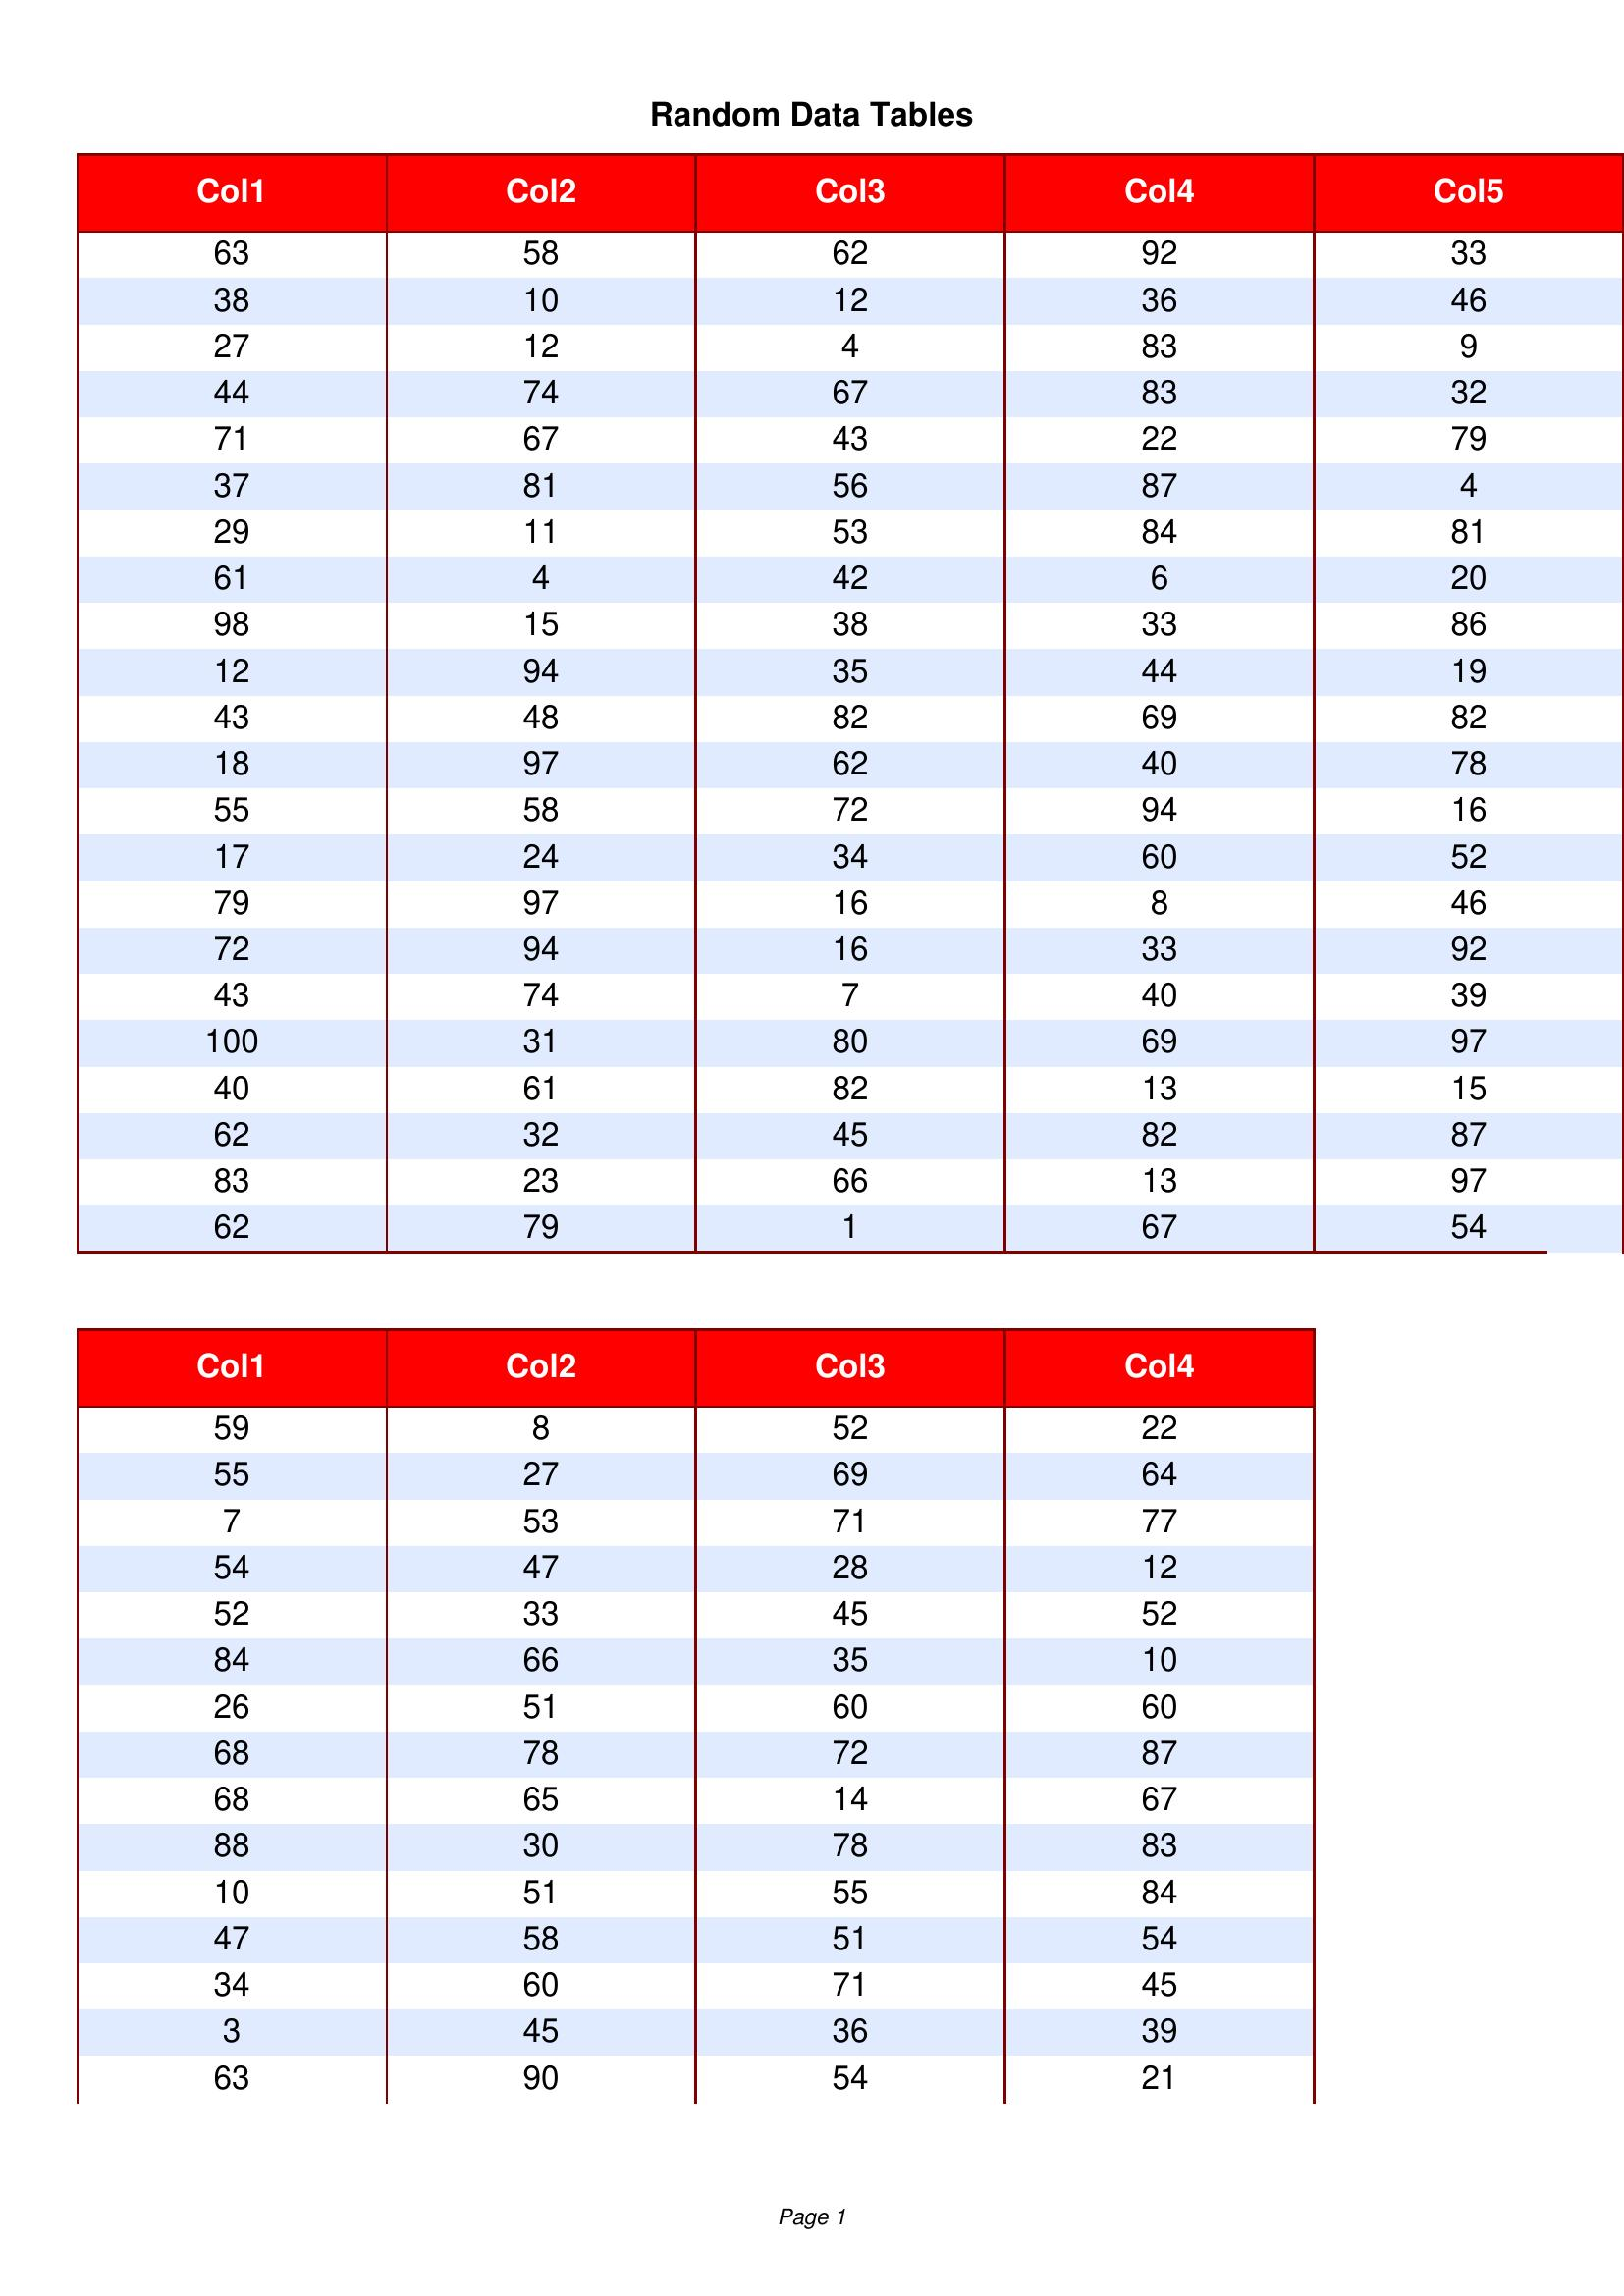

In [11]:
image

## Load model and processor

In [22]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

# # Doc Visual QA
# processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
# model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

# Parsing / Form Understanding
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.02M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/806M [00:00<?, ?B/s]

## Prepare using processor

We prepare the image for the model using `DonutProcessor`.

In [13]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 2560, 1920])


## Generate

Finally, we let the model autoregressively generate the answer to the question.

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# prepare decoder inputs
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

pixel_values = processor(image, return_tensors="pt").pixel_values

outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

/home/jack/miniconda3/envs/pdf/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:430: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [17]:
import re

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token

## Convert to JSON

We can convert the generated sequence to JSON if required:

In [18]:
print(processor.token2json(sequence))

{'text_sequence': '</s_answer>'}
